# Fragestellung: relative Abweichung zwischen Soll- und Istwert > 5% für einzelne Produkte. Liegt die Ursache in einer "empfindlichen" Chemie oder in der Technik begründet? -> Erzeugung eines Dentrogrammes, bei größerem Einfluss des Faktors "Chemie" sollten die einzelnen Produkte in einem Dentrogramm nah beeinander gruppiert sein.

## Um unterschiedliche Produkte miteinander vergleichen zu können, müssen Prozessgrößen normiert werden

## 1. Einlesen der Daten

In [1]:
import pandas as pd
import numpy as np
import csv
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [2]:
# Daten einlesen
df=pd.read_csv("process_data_df11.csv", header=[0,1], na_values=['nan'],
sep=',',low_memory=False)

# Spalte ohne Information löschen
df2=df.drop(['Unnamed: 0_level_0'],axis=1)


df2.head()

/home/alpha/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


ps                                                             \
             ps    ps_datum ps_beschichtete_rollenlange_m ps_c_losung_wt_%   
0  cb031d4b18ff  2018-05-13                        4487.0             31.0   
1  cb031d4b18ff  2018-05-13                        4487.0             31.0   
2  cb031d4b18ff  2018-05-13                        4487.0             31.0   
3  cb031d4b18ff  2018-05-13                        4487.0             31.0   
4  cb031d4b18ff  2018-05-13                        4487.0             31.0   

                                                                       \
  ps_gap_micro_m ps_dicke_as_micro_m ps_dicke_1 ps_dicke_2 ps_dicke_3   
0          250.0               136.0      136.0      134.0      134.0   
1          250.0               136.0      136.0      134.0      134.0   
2          250.0               136.0      136.0      134.0      134.0   
3          250.0               136.0      136.0      134.0      134.0   
4          250.0               136.0      136.0      134.0      134.0   

              ...             qc                                            \
  ps_dicke_4  ... qc_flux_l/m2/h qc_a-value_l/m2/h/bar qc_b-value_m/s_10-6   
0      135.0  ...      40.286235              4.625285            3.678446   
1      135.0  ...      40.252401              4.621401            3.165247   
2      135.0  ...      39.718186              4.560067            3.170593   
3      135.0  ...      39.441426              4.528292            2.855092   
4      135.0  ...      39.731817              4.561632            2.810373   

                                                    Sollwerte  \
  qc_flux_m3/m2/day sum_of_scrap roll_position soll_salzr_abs   
0          0.966870          0.0     58.181818           99.5   
1          0.966058          0.0    116.363636           99.5   
2          0.953236          0.0    174.545455           99.5   
3          0.946594          0.0    232.727273           99.5   
4          0.953564          0.0    290.909091           99.5   

                                                      
  soll_permeatd_abs soll_salzr_rel soll_permeatd_rel  
0              36.2       0.045087          1.707208  
1              36.2       0.030558          1.621790  
2              36.2       0.023437          0.273103  
3              36.2       0.067889          0.425610  
4              36.2       0.077781          0.307515  

[5 rows x 347 columns]

In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118670 entries, 0 to 118669
Columns: 347 entries, (ps, ps) to (Sollwerte, soll_permeatd_rel)
dtypes: bool(7), float64(300), int64(4), object(36)
memory usage: 308.6+ MB


In [4]:
df3=df2.copy()

In [5]:
df3=df3.droplevel(level=0,axis=1)

In [6]:
# Annahme: jedes Produkt besitzt einge Vorgaben für Prozessgrößen
# -> Normierung muss für jedes Produkt erfolgen
#  -> Entscheidend für die Fehleranfälligkeit ist Streuung der Prozessparameter um die Norm

df3=df3.set_index('p_product_full_name') #merken, um jedes produzierte Produkt zu identifizieren

## 2. Vorbereiten des Datensatzes für die Normierung

### 2.1 Typfilterung

In [7]:
# alle Prozessgrößen müssen Zahlen (int, float) sein
# Entfernen von allem, was keine Zahl ist

df3=df3.select_dtypes(include=['float64','int']) 

### 2.2 Entfernen von Spalten, die zwar typ: int oder typ: float sind, deren Normierung jedoch physikalisch nicht sinnvoll ist

In [8]:
df3=df3.drop(columns=['roll_position']) #Position, an der qc-Messung der Rolle stattfand
df3=df3.drop(columns=['qc_p_position','nr'])
#df3=df3.drop(columns=['nr'])




In [9]:
df3=df3.reset_index()

In [10]:
df3.head()

,p_product_full_name,ps_beschichtete_rollenlange_m,ps_c_losung_wt_%,ps_gap_micro_m,ps_dicke_as_micro_m,ps_dicke_1,ps_dicke_2,ps_dicke_3,ps_dicke_4,ps_dicke_bs,...,p_effective_pressure_bar,qc_flux_l/m2/h,qc_a-value_l/m2/h/bar,qc_b-value_m/s_10-6,qc_flux_m3/m2/day,sum_of_scrap,soll_salzr_abs,soll_permeatd_abs,soll_salzr_rel,soll_permeatd_rel
0,b3ccc5e5f9b5,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,134.0,...,8.71,40.286235,4.625285,3.678446,0.966870,0.0,99.5,36.2,0.045087,1.707208
1,b3ccc5e5f9b5,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,134.0,...,8.71,40.252401,4.621401,3.165247,0.966058,0.0,99.5,36.2,0.030558,1.621790
2,b3ccc5e5f9b5,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,134.0,...,8.71,39.718186,4.560067,3.170593,0.953236,0.0,99.5,36.2,0.023437,0.273103
3,b3ccc5e5f9b5,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,134.0,...,8.71,39.441426,4.528292,2.855092,0.946594,0.0,99.5,36.2,0.067889,0.425610
4,b3ccc5e5f9b5,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,134.0,...,8.71,39.731817,4.561632,2.810373,0.953564,0.0,99.5,36.2,0.077781,0.307515


In [11]:
#df3.groubby(['p_product_full_name'])

In [12]:
#is_p1=df3['p_product_full_name']=='0cc0ba87b12f'

In [13]:
#df_p1=df3[is_p1]

In [14]:
#df_p1

## 3. Normierung

In [15]:
# Liste mit allem Produktnamen 
# -> dient als Filter für Iteration
produktnamen=['a79cf6a73839','c807697b3c7e','f22a7fef71c5','c13b2f69d3c1','3e94b7067349','3394d82edc97','df9e75b29918','316c8d1ffca1','5661014763c8','73928f2577b5','22227b31350f','df1d09e643af','e2b1e6e1d5f5','54b98d0fe2eb','ff16223eb2bf','0cc0ba87b12f','a640f68db89c','b3ccc5e5f9b5','2256f65c362b','33d21930e431','3a0c28c7fc8c','630448a85ca3']

In [16]:
# Erzeugen eines leeren DataFrames, in welches die normierten Werte eingetragen werden
df_norm=pd.DataFrame()

for i in range(len(produktnamen)):
    
    # 1.Filtern nach Produktname und Erzeugen eines DataFrames, in welchem die Normierung erfolgt
    # !! Index ändert sich !!
    to_norm=df3['p_product_full_name']==produktnamen[i]
    df_n=df3[to_norm]
    
    # 2. Merken von Größen, welche nicht normieret werden können (product_name) oder es bereits sind (relative Werte)
    # !! Gleicher Index für diese Größen für df_n und df_n2 
    #  -> können später problemlos wieder angefügt werden
    df_n2=df_n.copy()
    df_n=df_n.drop(columns=['p_product_full_name','soll_salzr_rel', 'soll_permeatd_rel'])
    
    # Wahl der Normierungsmethode
    df_n=(df_n-df_n.min())/(df_n.max()-df_n.min())
    #df_n=(df_n-df_n.mean())/df_n.std()
    
    # Anfügen der Größen, welche nicht normiert werden sollen
    # sowie sukzessives Einfügen der normierten DataFrames in das leere DataFrame df_norm
    df_n['p_product_full_name']=df_n2['p_product_full_name']
    df_n['soll_salzr_rel']=df_n2['soll_salzr_rel']
    df_n['soll_permeatd_rel']=df_n2['soll_permeatd_rel']
    df_n.set_index('p_product_full_name')
    df_norm=df_norm.append(df_n, ignore_index=True)
    


In [17]:
df_norm

,ps_beschichtete_rollenlange_m,ps_c_losung_wt_%,ps_gap_micro_m,ps_dicke_as_micro_m,ps_dicke_1,ps_dicke_2,ps_dicke_3,ps_dicke_4,ps_dicke_bs,ps_raum_temperatur_start_c,...,qc_flux_l/m2/h,qc_a-value_l/m2/h/bar,qc_b-value_m/s_10-6,qc_flux_m3/m2/day,sum_of_scrap,soll_salzr_abs,soll_permeatd_abs,p_product_full_name,soll_salzr_rel,soll_permeatd_rel
0,1.000000,NaN,NaN,1.000000,1.000000,1.000,0.000,NaN,1.000,NaN,...,0.506699,0.506699,0.143686,0.506699,NaN,NaN,NaN,a79cf6a73839,0.106052,0.347577
1,1.000000,NaN,NaN,1.000000,1.000000,1.000,0.000,NaN,1.000,NaN,...,0.519579,0.519579,0.145616,0.519579,NaN,NaN,NaN,a79cf6a73839,0.102480,2.898316
2,1.000000,NaN,NaN,1.000000,1.000000,1.000,0.000,NaN,1.000,NaN,...,0.568144,0.568144,0.191241,0.568144,NaN,NaN,NaN,a79cf6a73839,0.163156,12.516333
3,1.000000,NaN,NaN,1.000000,1.000000,1.000,0.000,NaN,1.000,NaN,...,0.548385,0.548385,0.146440,0.548385,NaN,NaN,NaN,a79cf6a73839,0.088234,8.603211
4,1.000000,NaN,NaN,1.000000,1.000000,1.000,0.000,NaN,1.000,NaN,...,0.563722,0.563722,0.158999,0.563722,NaN,NaN,NaN,a79cf6a73839,0.104414,11.640462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118649,0.988792,NaN,NaN,0.444444,0.428571,0.375,0.625,0.444444,0.375,0.5,...,0.351294,0.351294,0.001043,0.351294,1.0,NaN,NaN,630448a85ca3,0.386905,20.371214
118650,0.988792,NaN,NaN,0.444444,0.428571,0.375,0.625,0.444444,0.375,0.5,...,0.350004,0.350004,0.001058,0.350004,1.0,NaN,NaN,630448a85ca3,0.402724,19.929047
118651,0.988792,NaN,NaN,0.444444,0.428571,0.375,0.625,0.444444,0.375,0.5,...,0.351034,0.351034,0.001075,0.351034,1.0,NaN,NaN,630448a85ca3,0.414076,20.282138
118652,0.988792,NaN,NaN,0.444444,0.428571,0.375,0.625,0.444444,0.375,0.5,...,0.368918,0.368918,0.001098,0.368918,1.0,NaN,NaN,630448a85ca3,0.388926,26.410032


In [18]:
df_norm2=df_norm.copy()

In [19]:
df_norm2=df_norm2.set_index('p_product_full_name')

In [20]:
df_norm2.head()

,ps_beschichtete_rollenlange_m,ps_c_losung_wt_%,ps_gap_micro_m,ps_dicke_as_micro_m,ps_dicke_1,ps_dicke_2,ps_dicke_3,ps_dicke_4,ps_dicke_bs,ps_raum_temperatur_start_c,...,p_effective_pressure_bar,qc_flux_l/m2/h,qc_a-value_l/m2/h/bar,qc_b-value_m/s_10-6,qc_flux_m3/m2/day,sum_of_scrap,soll_salzr_abs,soll_permeatd_abs,soll_salzr_rel,soll_permeatd_rel
p_product_full_name,,,,,,,,,,,,,,,,,,,,,
a79cf6a73839,1.0,NaN,NaN,1.0,1.0,1.0,0.0,NaN,1.0,NaN,...,NaN,0.506699,0.506699,0.143686,0.506699,NaN,NaN,NaN,0.106052,0.347577
a79cf6a73839,1.0,NaN,NaN,1.0,1.0,1.0,0.0,NaN,1.0,NaN,...,NaN,0.519579,0.519579,0.145616,0.519579,NaN,NaN,NaN,0.102480,2.898316
a79cf6a73839,1.0,NaN,NaN,1.0,1.0,1.0,0.0,NaN,1.0,NaN,...,NaN,0.568144,0.568144,0.191241,0.568144,NaN,NaN,NaN,0.163156,12.516333
a79cf6a73839,1.0,NaN,NaN,1.0,1.0,1.0,0.0,NaN,1.0,NaN,...,NaN,0.548385,0.548385,0.146440,0.548385,NaN,NaN,NaN,0.088234,8.603211
a79cf6a73839,1.0,NaN,NaN,1.0,1.0,1.0,0.0,NaN,1.0,NaN,...,NaN,0.563722,0.563722,0.158999,0.563722,NaN,NaN,NaN,0.104414,11.640462


In [21]:
# Filtert man das DataFrame nach den verschiedenen Produktname, treten Konstanten Spalten auf (z.B. ps_c_losung_wt_%)
# -> Annahme: Es handelt sich dabei um spezifische Vorgaben für die Produktion eines jeweiligen Produktes (weil sie eben nicht über im kompletten DataFrame konstant sind)
# -> Erzeugen NaN-Einträge, da beim Normieren durch 0 geteilt wird (df_n.max()=df_n.min())
#  -> Müssen Entfernt werden, da uns Schwankungen einzelner Prozessgrößen innerhalb eines Produktes interessieren

df_norm3=df_norm2.dropna(axis='columns', how='any')

In [22]:
df_norm3.head()

,ps_beschichtete_rollenlange_m,ps_dicke_1,ps_dicke_2,ps_dicke_3,ps_dicke_bs,ps_bad_temperatur_0m_c,ps_bad_temperatur_500m_c,ps_bad_temperatur_1000m_c,ps_bad_temperatur_1500m_c,ps_bad_temperatur_2000m_c,...,total_yield_%,qc_lasttest,qc_salzrckhalt,qc_durchfluss,qc_flux_l/m2/h,qc_a-value_l/m2/h/bar,qc_b-value_m/s_10-6,qc_flux_m3/m2/day,soll_salzr_rel,soll_permeatd_rel
p_product_full_name,,,,,,,,,,,,,,,,,,,,,
a79cf6a73839,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.25,0.999241,0.506699,0.506699,0.506699,0.143686,0.506699,0.106052,0.347577
a79cf6a73839,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.25,0.999277,0.519579,0.519579,0.519579,0.145616,0.519579,0.102480,2.898316
a79cf6a73839,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.25,0.998670,0.568144,0.568144,0.568144,0.191241,0.568144,0.163156,12.516333
a79cf6a73839,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.25,0.999420,0.548385,0.548385,0.548385,0.146440,0.548385,0.088234,8.603211
a79cf6a73839,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.25,0.999258,0.563722,0.563722,0.563722,0.158999,0.563722,0.104414,11.640462


In [23]:
# 116 Spalten von ursprünglich 347 noch übrig
df_norm3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118654 entries, a79cf6a73839 to 630448a85ca3
Columns: 118 entries, ps_beschichtete_rollenlange_m to soll_permeatd_rel
dtypes: float64(118)
memory usage: 107.7+ MB


## 4. Auswählen der Daten und Erzeugung eines Dentrogrammes

### 4.1 Salzrückhalt

#### 4.1.1 Filterkriterium

In [24]:
df_norm4=df_norm3[(df_norm3['soll_salzr_rel']>10) & (df_norm3['soll_salzr_rel']<100) ]

In [25]:
# Jeder 1000 Eintrag hat eine Abweichung größer als 5%
df_norm4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 316c8d1ffca1 to 630448a85ca3
Columns: 118 entries, ps_beschichtete_rollenlange_m to soll_permeatd_rel
dtypes: float64(118)
memory usage: 66.9+ KB


In [26]:
df_norm4.tail()

,ps_beschichtete_rollenlange_m,ps_dicke_1,ps_dicke_2,ps_dicke_3,ps_dicke_bs,ps_bad_temperatur_0m_c,ps_bad_temperatur_500m_c,ps_bad_temperatur_1000m_c,ps_bad_temperatur_1500m_c,ps_bad_temperatur_2000m_c,...,total_yield_%,qc_lasttest,qc_salzrckhalt,qc_durchfluss,qc_flux_l/m2/h,qc_a-value_l/m2/h/bar,qc_b-value_m/s_10-6,qc_flux_m3/m2/day,soll_salzr_rel,soll_permeatd_rel
p_product_full_name,,,,,,,,,,,,,,,,,,,,,
630448a85ca3,0.988792,0.571429,0.625,0.750,0.625,0.115702,0.093750,0.157895,0.200000,0.181818,...,0.988889,0.666667,0.241982,0.956561,0.956561,0.956561,1.000000,0.956561,75.739338,227.766230
630448a85ca3,0.983811,0.571429,0.750,0.875,1.000,0.107438,0.083333,0.144737,0.183333,0.159091,...,0.766667,0.333333,0.626512,0.563073,0.563073,0.563073,0.112392,0.563073,37.187137,92.937199
630448a85ca3,0.843088,0.428571,0.500,0.625,0.625,0.132231,0.114583,0.144737,0.166667,0.136364,...,0.744444,0.666667,0.335836,0.754659,0.754659,0.754659,0.498295,0.754659,66.329747,158.584149
630448a85ca3,0.845579,0.428571,0.500,0.500,0.500,0.148760,0.125000,0.184211,0.216667,0.159091,...,0.966667,0.666667,0.884449,0.394116,0.394116,0.394116,0.017490,0.394116,11.326925,35.044016
630448a85ca3,0.940224,0.714286,0.750,0.750,0.875,0.099174,0.052083,0.105263,0.150000,0.136364,...,0.833333,0.666667,0.634598,0.496583,0.496583,0.496583,0.095752,0.496583,36.376511,70.154356


#### 4.1.2 Erzeugung der Labels

In [27]:
df_norm5=df_norm4.copy()

In [28]:
df_norm5=df_norm5.sort_index()
df_norm5.head()

,ps_beschichtete_rollenlange_m,ps_dicke_1,ps_dicke_2,ps_dicke_3,ps_dicke_bs,ps_bad_temperatur_0m_c,ps_bad_temperatur_500m_c,ps_bad_temperatur_1000m_c,ps_bad_temperatur_1500m_c,ps_bad_temperatur_2000m_c,...,total_yield_%,qc_lasttest,qc_salzrckhalt,qc_durchfluss,qc_flux_l/m2/h,qc_a-value_l/m2/h/bar,qc_b-value_m/s_10-6,qc_flux_m3/m2/day,soll_salzr_rel,soll_permeatd_rel
p_product_full_name,,,,,,,,,,,,,,,,,,,,,
0cc0ba87b12f,0.012576,0.333333,0.2,0.2500,0.285714,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.455635,0.5,0.762383,0.496312,0.496312,0.496312,0.450954,0.496312,23.378572,43.715483
0cc0ba87b12f,0.012576,0.333333,0.2,0.2500,0.285714,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.455635,0.5,0.653932,0.648182,0.648182,0.648182,1.000000,0.648182,34.278185,87.692217
22227b31350f,0.084871,0.470588,0.4,0.4375,0.421053,0.767442,0.921397,0.931624,0.933610,0.946721,...,0.897959,0.4,0.866718,0.581556,0.581556,0.581556,0.309397,0.581556,12.892626,35.749183
22227b31350f,0.084756,0.294118,0.2,0.1875,0.263158,0.627907,0.908297,0.905983,0.892116,0.889344,...,0.826531,0.4,0.875504,0.622749,0.622749,0.622749,0.306367,0.622749,12.009655,45.364499
22227b31350f,0.085374,0.235294,0.2,0.3125,0.368421,0.186047,0.925764,0.910256,0.904564,0.901639,...,0.112245,0.4,0.892636,0.577466,0.577466,0.577466,0.240294,0.577466,10.287840,34.794443


In [29]:
df_norm5=df_norm5.reset_index()

In [30]:
df_norm5.head()

,p_product_full_name,ps_beschichtete_rollenlange_m,ps_dicke_1,ps_dicke_2,ps_dicke_3,ps_dicke_bs,ps_bad_temperatur_0m_c,ps_bad_temperatur_500m_c,ps_bad_temperatur_1000m_c,ps_bad_temperatur_1500m_c,...,total_yield_%,qc_lasttest,qc_salzrckhalt,qc_durchfluss,qc_flux_l/m2/h,qc_a-value_l/m2/h/bar,qc_b-value_m/s_10-6,qc_flux_m3/m2/day,soll_salzr_rel,soll_permeatd_rel
0,0cc0ba87b12f,0.012576,0.333333,0.2,0.2500,0.285714,1.000000,1.000000,1.000000,1.000000,...,0.455635,0.5,0.762383,0.496312,0.496312,0.496312,0.450954,0.496312,23.378572,43.715483
1,0cc0ba87b12f,0.012576,0.333333,0.2,0.2500,0.285714,1.000000,1.000000,1.000000,1.000000,...,0.455635,0.5,0.653932,0.648182,0.648182,0.648182,1.000000,0.648182,34.278185,87.692217
2,22227b31350f,0.084871,0.470588,0.4,0.4375,0.421053,0.767442,0.921397,0.931624,0.933610,...,0.897959,0.4,0.866718,0.581556,0.581556,0.581556,0.309397,0.581556,12.892626,35.749183
3,22227b31350f,0.084756,0.294118,0.2,0.1875,0.263158,0.627907,0.908297,0.905983,0.892116,...,0.826531,0.4,0.875504,0.622749,0.622749,0.622749,0.306367,0.622749,12.009655,45.364499
4,22227b31350f,0.085374,0.235294,0.2,0.3125,0.368421,0.186047,0.925764,0.910256,0.904564,...,0.112245,0.4,0.892636,0.577466,0.577466,0.577466,0.240294,0.577466,10.287840,34.794443


In [31]:
prod_appearance=df_norm5['p_product_full_name'].tolist()
prod_appearance_if_cond=prod_appearance.copy() # Vergleichsbedingung; ursprüngliche List wird überschrieben werden

In [32]:
prod_appearance

['0cc0ba87b12f',
 '0cc0ba87b12f',
 '22227b31350f',
 '22227b31350f',
 '22227b31350f',
 '22227b31350f',
 '22227b31350f',
 '22227b31350f',
 '22227b31350f',
 '22227b31350f',
 '22227b31350f',
 '22227b31350f',
 '2256f65c362b',
 '2256f65c362b',
 '2256f65c362b',
 '316c8d1ffca1',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '3a0c28c7fc8c',
 '5661014763c8',
 '5661014763c8',
 '5661014763c8',
 '5661014763c8',
 '5661014763c8',
 '630448a85ca3',
 '630448a85ca3',
 '630448a85ca3',
 '630448a85ca3',
 '630448a85ca3',
 '630448a85ca3',
 '630448a85ca3',
 '73928f2577b5',
 '73928f2577b5',
 '73928f2577b5',
 '73928f2577b5',
 '73928f2577b5',
 '73928f2577b5',
 '73928f2577b5',
 '73928f2577b5',
 '73928f2577b5',
 '73928f2577b5',
 'a640f68db89c',
 'b3ccc5e5f9b5',
 'b3ccc5e5f9b5',
 'df1d09e643af',
 'df1d09e643af',
 'e2b1e6e1d5f5',
 'e2b1e6e1d5f5',
 'ff16223eb2bf

In [34]:
# Durchnummerieren der einzelnen Produkte
for i in range(len(prod_appearance)):
    if i==0:
        j=1
        prod_appearance[i]=prod_appearance[i][:4]+"_"+str(j)
    elif prod_appearance_if_cond[i]==prod_appearance_if_cond[i-1]:
        j=j+1
        prod_appearance[i]=prod_appearance[i][:4]+"_"+str(j)
    else:
        j=1
        prod_appearance[i]=prod_appearance[i][:4]+"_"+str(j)
    
        

In [ ]:
#prod_appearance[1][:4]
    

In [35]:
df_norm6=df_norm5.drop(columns=['p_product_full_name','soll_salzr_rel', 'soll_permeatd_rel'])

In [ ]:
df_norm6.head()

In [36]:
df_norm_dendro=df_norm6.to_numpy()

In [37]:
mergings=linkage(df_norm_dendro, method='complete')

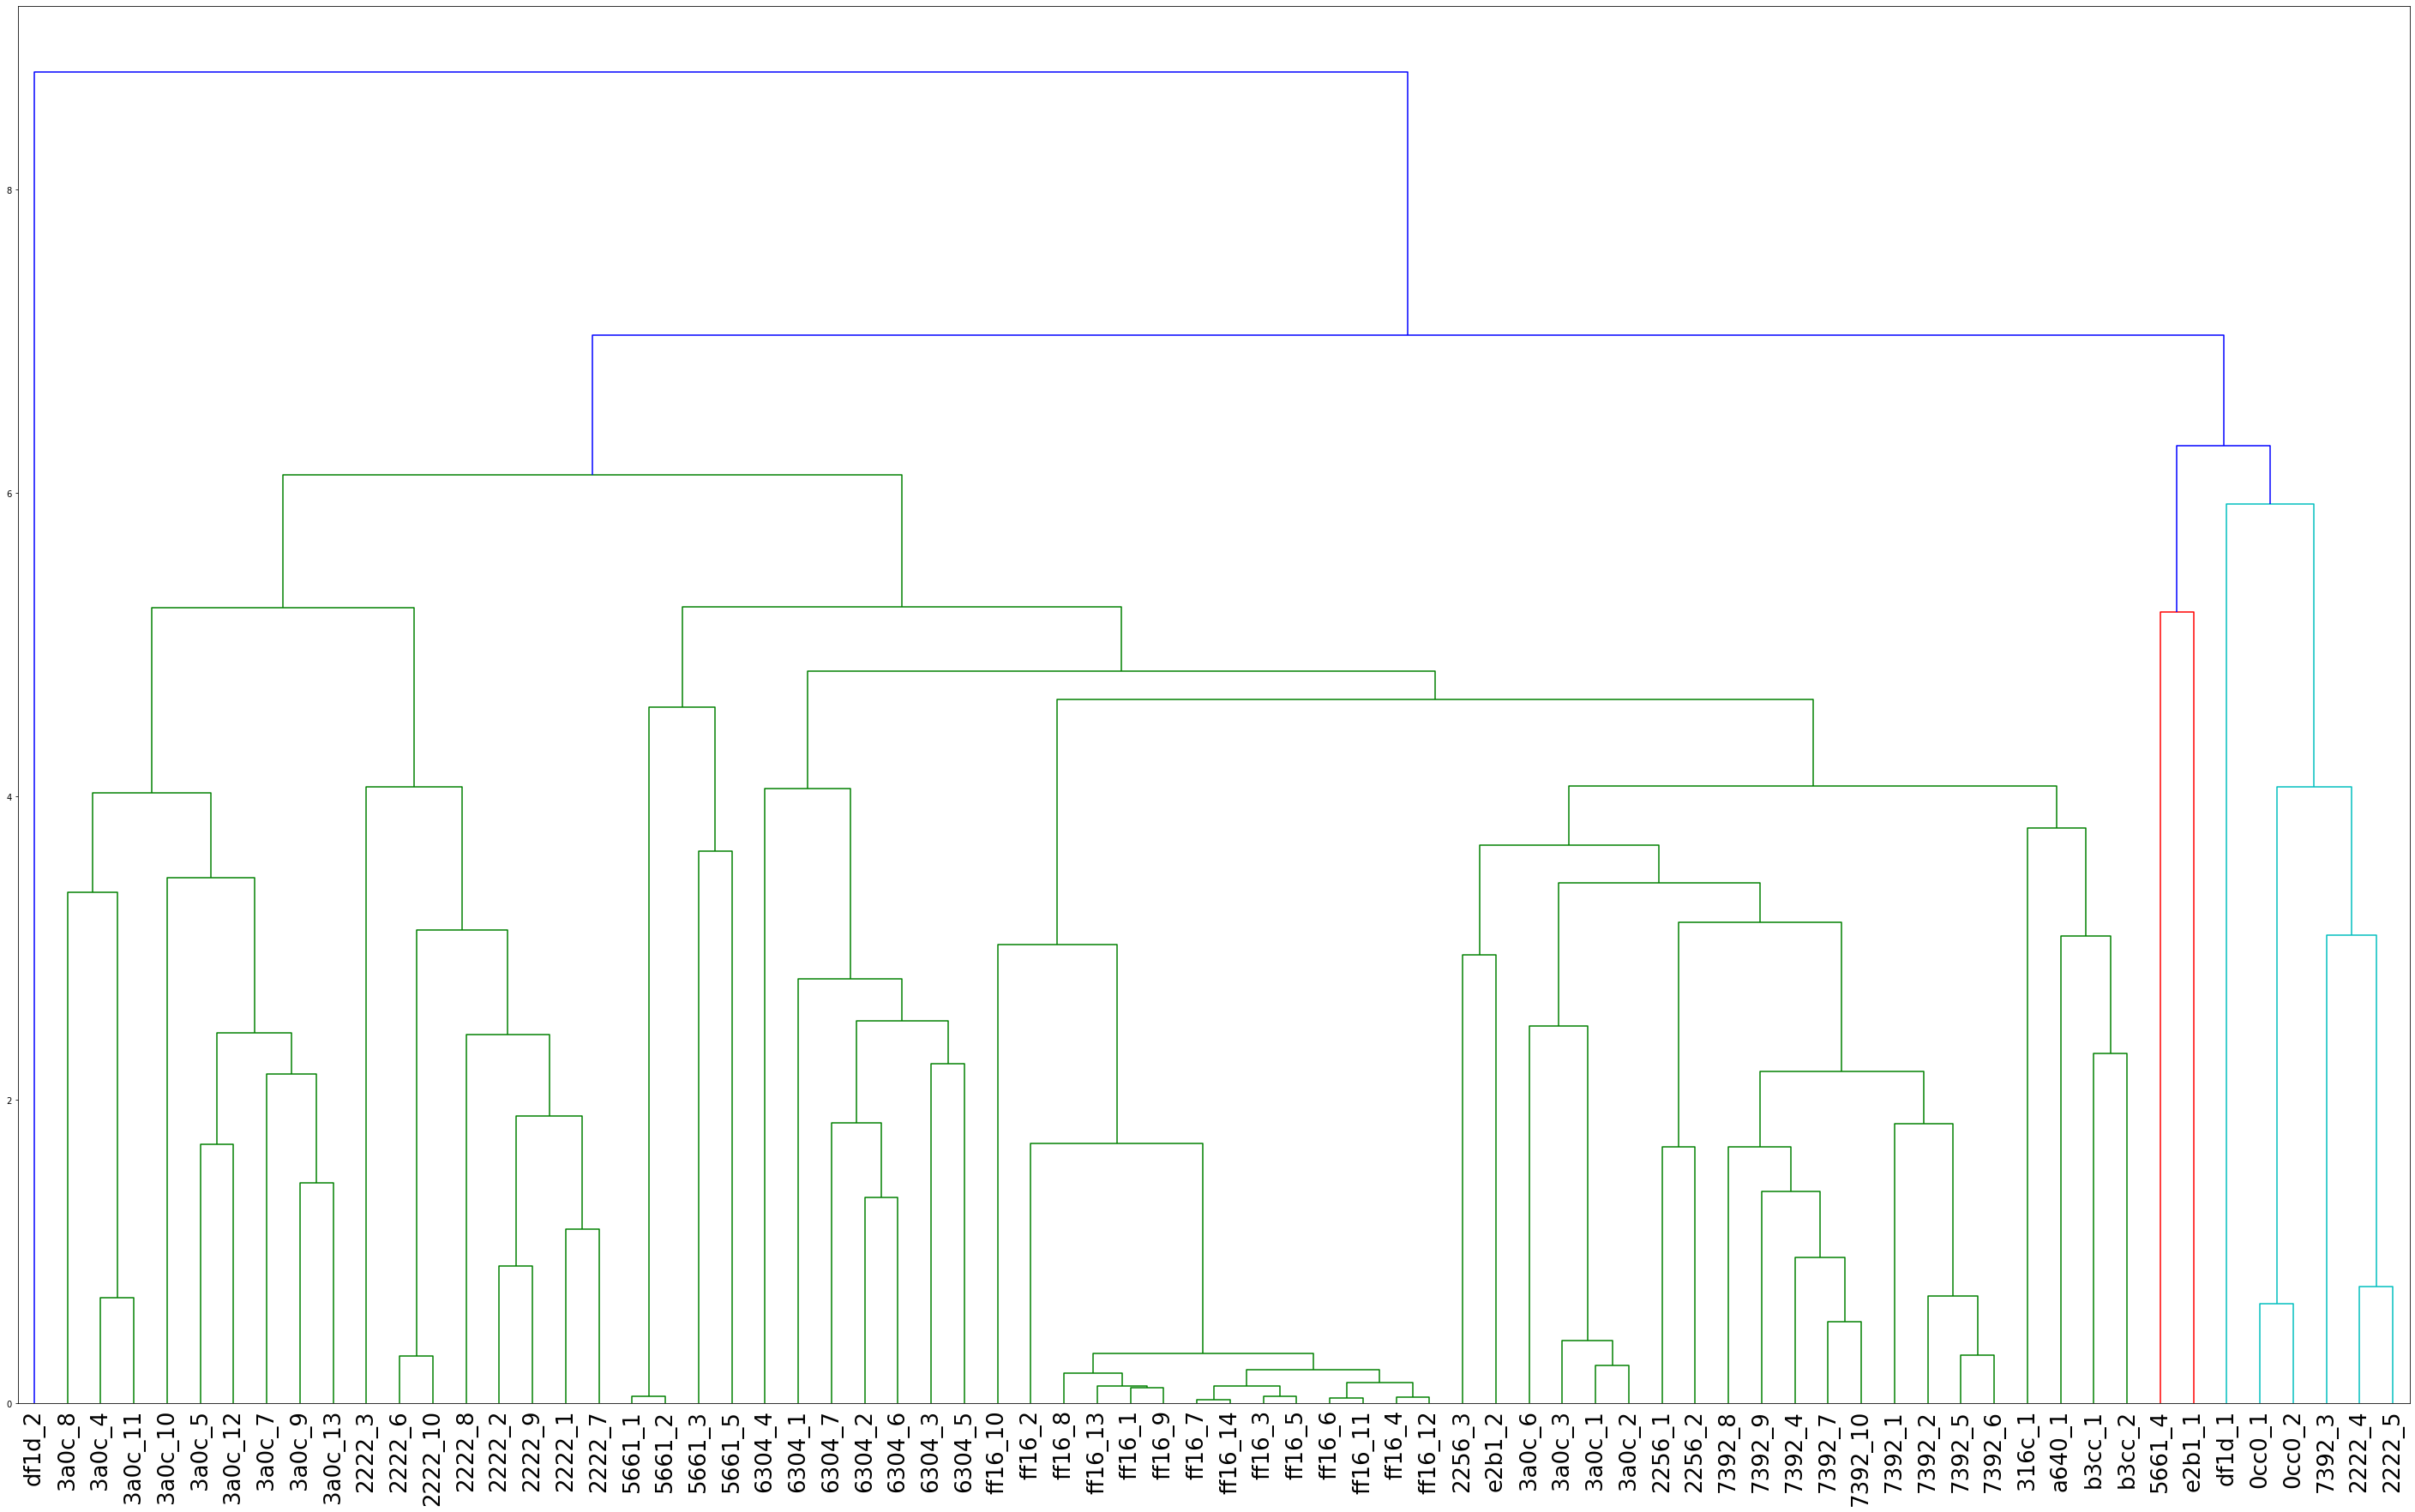

In [46]:
plt.figure(figsize=(50,30))
dendrogram(mergings,labels=prod_appearance, leaf_rotation=90, leaf_font_size=26,)
plt.show()